# Vector Query the Database

Now we have created the database, we need to test whether the embeddings have worked and we can query it to return a meaningful result. 

In [3]:
import numpy as np
import hnswlib
import clip
import torch
import os
import psutil
from PIL import Image
from IPython.display import display

In [4]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load HNSWlib index and image ids
hnsw_index_path = '../data/processed/hnsw_index.bin'
image_ids_path = '../data/processed/image_ids.npy'
image_folder_path = '../data/raw/images'

# Load the index
hnsw_index = hnswlib.Index(space='l2', dim=512)
hnsw_index.load_index(hnsw_index_path)
image_ids = np.load(image_ids_path)

def generate_text_embedding(text, model, device):
    text_input = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_input).cpu().numpy().flatten()
    # Normalize the embedding
    text_embedding = text_embedding / np.linalg.norm(text_embedding)
    return text_embedding

def search_similar_images(index, query_embedding, image_ids, top_k=5):
    labels, distances = index.knn_query(query_embedding, k=top_k)
    similar_image_ids = [image_ids[i] for i in labels[0]]
    return similar_image_ids

def query_images(query_text, top_k=5):
    query_embedding = generate_text_embedding(query_text, model, device)
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    similar_image_ids = search_similar_images(hnsw_index, query_embedding, image_ids, top_k)
    image_paths = [os.path.join(image_folder_path, f"{image_id}.jpg") for image_id in similar_image_ids]
    return image_paths

def display_images(image_paths, max_images=5):
    for i, image_path in enumerate(image_paths):
        if i >= max_images:
            break
        if os.path.exists(image_path):
            img = Image.open(image_path)
            display(img)
        else:
            print(f"Image {image_path} not found")

# Monitor system resources
def monitor_resources():
    process = psutil.Process(os.getpid())
    print(f"Memory Usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")
    print(f"CPU Usage: {psutil.cpu_percent(interval=1)}%")


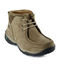

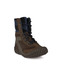

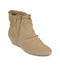

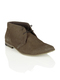

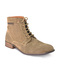

In [9]:
# Example usage
query_text = "comfy boots casual female"
image_paths = query_images(query_text, top_k=5)
display_images(image_paths)